In [1]:
import glob
import os
import torch
import sys
from metrics_cond import *
import slice_view
import torch.nn.functional as F
import nibabel as nib
from matplotlib import pyplot as plt
import numpy as np
from tqdm import tqdm
from torch.utils.data import DataLoader



In [2]:


# Normalize tensors
def normalize_tensor(tensor, min_range, max_range):
    min_vals = torch.min(tensor, dim=2).values.min(dim=2).values
    max_vals = torch.max(tensor, dim=2).values.max(dim=2).values
    normalized_tensor = (tensor - min_vals.unsqueeze(2).unsqueeze(3)) / (max_vals.unsqueeze(2).unsqueeze(3) - min_vals.unsqueeze(2).unsqueeze(3))
    normalized_tensor = normalized_tensor * (max_range - min_range) + min_range
    return normalized_tensor

def load_data(model):
    """Load test datasets."""    
    model.val_data = model.conf.make_dataset(
        path=model.conf.data_config_path,
        csv_path=model.conf.csv_path_test,
        h5_save_path=model.conf.h5_save_path_test,
        csv_file_name=model.conf.csv_file_name_test,
        csv_mask_name=model.conf.csv_mask_name_test,
        ventricle_mask_root_path=model.conf.ventricle_mask_root_path,
        mode_='test'
    )
    print('val data:', len(model.val_data))
    return model

def create_dataloaders(model, batch_size=50, batch_size_eval=50):
    """Create DataLoaders for test data."""
    test_dataloader = DataLoader(model.val_data, shuffle=False, batch_size=batch_size_eval, num_workers=1, pin_memory=True)
    return test_dataloader

def process_batch(batch, model, mode='train', start_from_noise=False, use_mask_=True, device='cuda'):
    """Process a batch to generate follow-up images."""
    # Set model to evaluation mode and move to GPU
    with torch.no_grad():
        model.eval()
        model.cuda()
        model.model.eval()
        model.model.cuda()
    #Sampling time-steps
    T_s = 50

    # Extract and normalize batch data
    ventricle_mask_batch = batch['ventricle_mask']
    x_start = normalize_tensor(batch['_'+mode+'_image'], 0, 1)
    x_start_baseline = normalize_tensor(batch['_'+mode+'_baseline_image'], 0, 1).cuda()
    idxs = batch['idx']

    # Calculate age difference
    age_diff = model.str_list_tensor(batch['Age']) - model.str_list_tensor(batch['baseline Age'])
    age_diff = age_diff.to(batch['_'+mode+'_image'].dtype)

    # Initialize and prepare condition vectors
    cond_vector = torch.zeros(batch['_'+mode+'_image'].shape[0], 12)
    cond_vector, shifts, cond_vector_shift = model.get_data_elements(batch, age_diff, cond_vector)
    health_state = cond_vector_shift
    cond_vector_shift = cond_vector_shift.to(age_diff.dtype).to(age_diff.device)
    cond_vector = cond_vector.to(age_diff.dtype).to(age_diff.device)
    x_start = x_start.cuda()

    # Generate noise for diffusion
    noise = torch.randn(x_start.shape[0], 1, x_start.shape[2], x_start.shape[3], device=x_start.device)

    # Configure sampler
    model.sampler.ventricle_mask_batch = ventricle_mask_batch
    model.sampler.age_shift = shifts.to(batch['_'+mode+'_image'].dtype).to(batch['_'+mode+'_image'].device)
    model.sampler.cond_shift_weight = 1

    # Predict latent shift
    shift_predictor = model.model.latent_shift_predictor
    shift_predictor.eval()
    shift_new = shift_predictor.forward(cond_vector_shift.cuda())

    # Encode baseline image
    cond_baseline = model.encode(batch['_'+mode+'_baseline_image'].to(device))
    if not start_from_noise:
        xT = model.encode_stochastic(batch['_'+mode+'_baseline_image'].to(device), cond_baseline, T=200,
                                    x_start_baseline=x_start_baseline.cuda(), age_diff=age_diff.cuda(),
                                    health_state=health_state.cuda())

    # Modify shift for zero age difference
    shift_new_modf = shift_new.clone()
    for ind_, diff in enumerate(age_diff):
        if diff == 0:
            shift_new_modf[ind_][0:50] = shift_new_modf[ind_][450:500]

    # Select starting point for rendering
    start_ = noise if start_from_noise else xT

    # Render follow-up image
    if use_mask_:
        pred_followup_xT_shift_ = model.render(start_, {'cond': cond_baseline + (shift_new_modf)}, T=T_s,
                                               mask_mult=True,
                                               gt=batch['_'+mode+'_baseline_image'].to(device),
                                               gt_keep_mask=ventricle_mask_batch.to(device),
                                               health_state=cond_vector_shift.to(device))
    else:
        pred_followup_xT_shift_ = model.render(start_, {'cond': cond_baseline + (shift_new_modf)}, T=T_s,
                                               mask_mult=False,
                                               health_state=cond_vector_shift.to(device))

    # Apply label mask to images
    pred_followup_xT_shift = pred_followup_xT_shift_ * batch['_'+mode+'_label'].to(torch.float32).cuda()
    x_start_ = x_start * batch['_'+mode+'_label'].to(torch.float32).cuda()
    x_start_baseline_ = x_start_baseline * batch['_'+mode+'_label'].to(torch.float32).cuda()

    return pred_followup_xT_shift, x_start_, x_start_baseline_, batch

def save_results(pred_followup_xT_shift, x_start_, x_start_baseline_, batch, save_=False, save_path='./save_results/'):
    """Save batch results to a .pt file."""
    # Convert ages to tensors
    starting_age = torch.tensor(float(batch['baseline Age'][0]))
    followup_age = torch.tensor(float(batch['Age'][0]))

    # Print subject info
    print('Subject:', batch['nii path'][0].split('/')[-1])
    print("Baseline Age: ", batch['baseline Age'][0])
    print('Follow-up Age: ', batch['Age'][0])
    print('Cognitive State: ', batch['Health status'][0])

    # Create results dictionary
    save_dict = {
        'pred_followup_xT_shift': pred_followup_xT_shift,
        'x_start_': x_start_,
        'x_start_baseline_': x_start_baseline_,
        'baseline Age': batch['baseline Age'][0],
        'Age': batch['Age'][0],
        'Health status': batch['Health status'],
        'baseline nii path': batch['baseline nii path'][0],
        'nii path': batch['nii path'][0]
    }
    if save_:
        # Generate unique ID and save
        uniq_id = batch['Subject'][0]+'_'+str(round(followup_age.item(),2))+'_'+str(round(starting_age.item(),2))+'.pt'
        if not os.path.exists(save_path):
            os.mkdir(save_path)
        torch.save(save_dict, save_path + uniq_id)
    return save_dict



Seed set to 0


Model params: 129.18 M


In [3]:

# Load model
import AD_DAE_model_call as model_call
root_path_ = '/home/projects/medimg/ayantika/Ayantika/Diff_AE_xstart_w_xbsln_disentangle_unsup/AD_DAE_files/'
model = model_call.AD_DAE_model_call_func(root_path=root_path_,\
                          checkpoint_path = '/home/projects/medimg/ayantika/Ayantika/results/AD_DAE_new_train/ADNI_AD_CN_MCI/')
    
"""Main function to run AD-DAE inference."""
# Get model configuration
conf = model.conf
device = 'cuda'

# Lambda for age list to tensor conversion
str_float_tensor = lambda age_list: torch.stack([torch.tensor(float(age)) for age in age_list])
model.str_list_tensor = str_float_tensor

# Load datasets
model = load_data(model)

#if data_store is empty h5 files not created then lower batch is better
if os.listdir('./data_store/'):
    # Create DataLoader
    test_dataloader = create_dataloaders(model,batch_size=50, batch_size_eval=50)
else:
    # Create DataLoader
    test_dataloader = create_dataloaders(model,batch_size=1, batch_size_eval=1)

# Process one batch (original code has break)
for i,batch in enumerate(tqdm(test_dataloader, total=len(test_dataloader))):
#     if i==12:
    pred_followup_xT_shift, x_start_, x_start_baseline_, batch = process_batch(batch, model,mode='test')
    save_dict = save_results(pred_followup_xT_shift, x_start_, x_start_baseline_, batch)
#     break

# if __name__ == "__main__":
#     main()

self.data_name ADNI
val data: 50


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:57<00:00, 117.55s/it]

Subject: ADNI_062_S_0793_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20081230153105872_S60719_I132424.nii
Baseline Age:  69.5
Follow-up Age:  71.3
Cognitive State:  AD


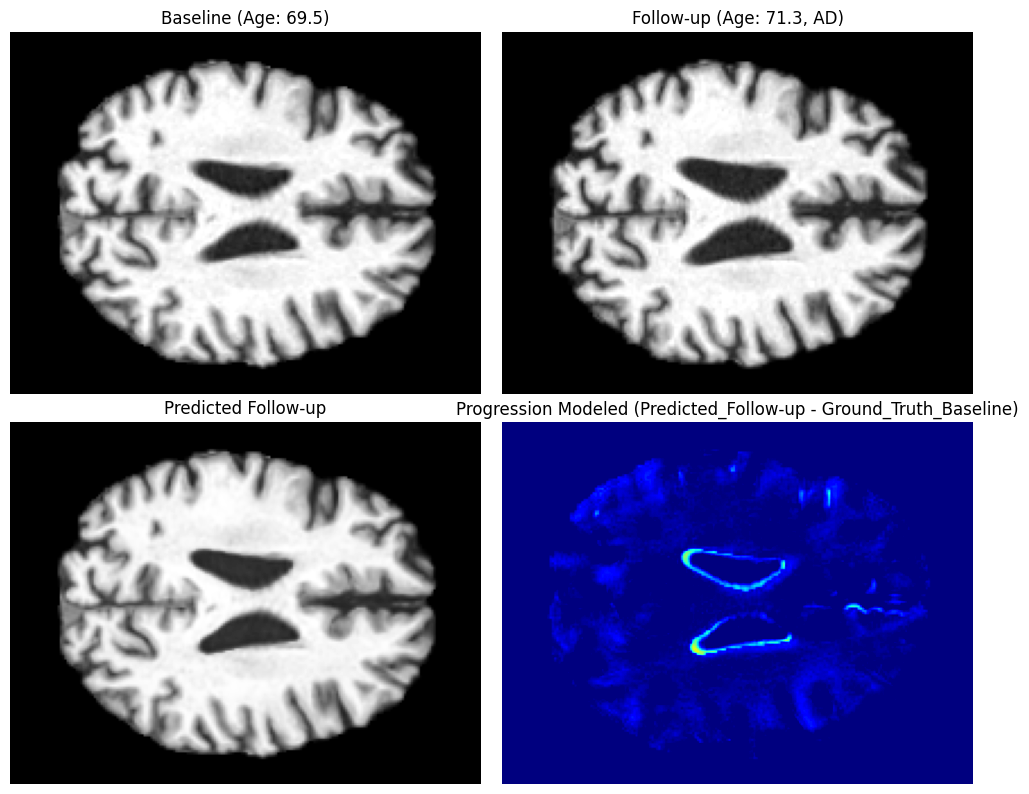

In [4]:
index_ = 40
# Extract 2D slices (batch, channel, height, width) -> (height, width)
baseline = save_dict['x_start_baseline_'][index_,0,:,:].detach().cpu()
followup = save_dict['x_start_'][index_,0,:,:].detach().cpu()
predicted = save_dict['pred_followup_xT_shift'][index_,0,:,:].detach().cpu()
residual = predicted - followup   # Compute residual
progression = predicted - baseline

# Create 2x2 subplot grid
fig, axes = plt.subplots(2, 2, figsize=(10, 8))

# Plot baseline
axes[0, 0].imshow(baseline, cmap='gray')
axes[0, 0].set_title(f"Baseline (Age: {save_dict['baseline Age']})")
axes[0, 0].axis('off')

# Plot follow-up
axes[0, 1].imshow(followup, cmap='gray')
axes[0, 1].set_title(f"Follow-up (Age: {save_dict['Age']}, {save_dict['Health status'][0]})")
axes[0, 1].axis('off')

# Plot predicted follow-up
axes[1, 0].imshow(predicted, cmap='gray')
axes[1, 0].set_title("Predicted Follow-up")
axes[1, 0].axis('off')

# Plot residual
im = axes[1, 1].imshow(-progression, cmap='jet',vmin=0, vmax=0.5)
axes[1, 1].set_title("Progression Modeled (Predicted_Follow-up - Ground_Truth_Baseline)")
axes[1, 1].axis('off')
# plt.colorbar(im, ax=axes[1, 1], fraction=0.046, pad=0.04)

# Adjust layout and save
plt.tight_layout()


In [91]:
#3D Loading of Ground-truth
slc = slice_view.slicer((save_dict['x_start_'])[:,0,:,:].detach().cpu())
slc.slicer_view()

interactive(children=(Dropdown(description='slice_view', options=('x', 'y', 'z'), value='x'), IntSlider(value=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [92]:
#3D Loading of Generated Images
slc = slice_view.slicer((save_dict['pred_followup_xT_shift'])[:,0,:,:].detach().cpu())
slc.slicer_view()

interactive(children=(Dropdown(description='slice_view', options=('x', 'y', 'z'), value='x'), IntSlider(value=…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>